In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense,Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
df = pd.read_csv('drive/MyDrive/ASN00003.csv')
df.head()

,Unnamed: 0,battery_pack_status_identifier,asset_serial_number,battery_pack_identifier,record_create_date,record_create_timestamp,state_of_charge,energy_consumption,battery_lifetime,max_cell_temperature,min_cell_temperature
0,94,95.0,ASN00003,BAT00003,01-05-2023,01-05-2023 16:22,86.2,2872300.0,1892.538,17.531,16.563
1,96,97.0,ASN00003,BAT00003,01-05-2023,01-05-2023 16:32,83.4,2873300.0,1892.710,18.188,16.906
2,98,99.0,ASN00003,BAT00003,01-05-2023,01-05-2023 16:42,80.9,2874200.0,1892.876,18.844,17.250
3,100,101.0,ASN00003,BAT00003,01-05-2023,01-05-2023 16:53,77.9,2875300.0,1893.049,19.469,17.719
4,102,103.0,ASN00003,BAT00003,01-05-2023,01-05-2023 17:03,75.1,2876200.0,1893.221,20.031,18.219


In [ ]:
train_dates = pd.to_datetime(df['record_create_timestamp'])

In [ ]:
print(train_dates.tail(15))

1332   2023-05-24 11:57:00
1333   2023-05-24 12:07:00
1334   2023-05-24 12:18:00
1335   2023-05-24 12:28:00
1336   2023-05-24 12:38:00
1337   2023-05-24 12:48:00
1338   2023-05-24 12:58:00
1339   2023-05-24 13:09:00
1340   2023-05-24 13:19:00
1341   2023-05-24 13:29:00
1342   2023-05-24 13:40:00
1343   2023-05-24 13:50:00
1344   2023-05-24 14:00:00
1345   2023-05-24 14:10:00
1346   2023-05-24 14:21:00
Name: record_create_timestamp, dtype: datetime64[ns]


In [ ]:
cols = list(df)[6:11]
print(cols)

['state_of_charge', 'energy_consumption', 'battery_lifetime', 'max_cell_temperature', 'min_cell_temperature']


In [ ]:
df_for_training = df[cols].astype(float)

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [ ]:
trainX = []
trainY = []

In [ ]:
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 31

In [ ]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [ ]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1316, 31, 5).
trainY shape == (1316, 1).


In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 31, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
74/74 [==============================] - 12s 53ms/step - loss: 0.5129 - val_loss: 0.0981
Epoch 2/5
74/74 [==============================] - 4s 58ms/step - loss: 0.1779 - val_loss: 0.0492
Epoch 3/5
74/74 [==============================] - 4s 55ms/step - loss: 0.1275 - val_loss: 0.0549
Epoch 4/5
74/74 [==============================] - 3s 47ms/step - loss: 0.1073 - val_loss: 0.0405
Epoch 5/5
74/74 [==============================] - 3s 47ms/step - loss: 0.1030 - val_loss: 0.0266


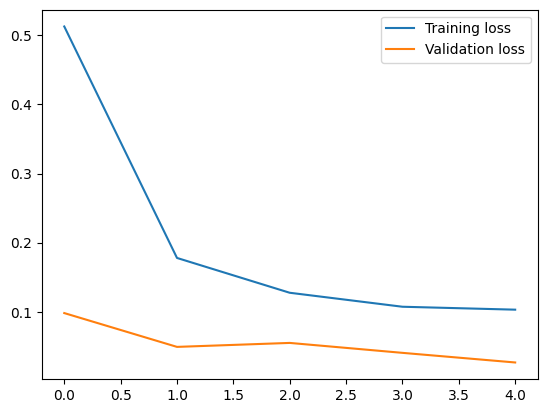

In [ ]:
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [ ]:
n_future = 10
forecast_period_dates = pd.date_range(list(train_dates)[-1],periods=n_future, freq=us_bd).tolist()
forecast = model.predict(trainX[-n_future:])

1/1 [==============================] - 0s 276ms/step


In [ ]:
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [ ]:
print(y_pred_future)

[91.70842  92.110245 92.518684 92.90817  93.28862  93.65896  94.02779
 94.39671  94.736946 95.01224 ]
